Задание выполнила Казакова Анастасия

**1. Приступаем к вычищению ботных и некорректных данных из visits.csv.**

In [ ]:
# Подключаем библиотеки
import numpy as np
import pandas as pd
import sqlite3

# Создаем sqlite db в памяти
conn = sqlite3.connect(":memory:")

# Читаем csv-файлы
visits = pd.read_csv("/content/drive/MyDrive/Sputnik_test/visits.csv")
views = pd.read_csv("/content/drive/MyDrive/Sputnik_test/views.csv")
orders = pd.read_csv("/content/drive/MyDrive/Sputnik_test/orders.csv")

# DataFrame -> SQL DB
# visits.to_sql("visits", conn, index=False, if_exists="replace", dtype={"id": "INTEGER PRIMARY KEY"})
views.to_sql("views", conn, index=False, if_exists="replace", dtype={"id": "INTEGER PRIMARY KEY"})
orders.to_sql("orders", conn, index=False, if_exists="replace", dtype={"id": "INTEGER PRIMARY KEY"})

22228

Сначала я хотела сделать PRIMARY KEY по id для таблицы visits, так как по логике они должны быть в одном экземпляре, но компилятор выдал ошибку (UNIQUE constraint failed: visits.id). Соответвенно, мы уже видим, что помимо информации из пункта а, существует много других некорректных данных (дубликаты). Посмотрим на дубликаты и уберем их. Только после этого преобразуем df в sql таблицу.

In [ ]:
# Получаем количество строк таблиц
visits_row_amount = visits.shape[0]
print(f"Всего в таблице visits {visits_row_amount} строк.")

Всего в таблице visits 850912 строк.


In [ ]:
duplicates = visits[visits.duplicated(subset="id", keep=False)].sort_values("id")
duplicates.head(10)

,Unnamed: 0,started_at,id,utm_medium,device_type,utm_source,browser
211787,211787,2024-05-15 14:29:51.115314,611483773,organic,Mobile,yandex,Yandex Browser
211786,211786,2024-05-15 14:29:51.115314,611483773,organic,Mobile,yandex,Yandex Browser
435946,435946,2024-05-15 14:30:00.577142,611483919,organic,Mobile,google,Microsoft Edge
435945,435945,2024-05-15 14:30:00.577142,611483919,organic,Mobile,google,Microsoft Edge
437731,437731,2024-05-15 14:30:25.743519,611484325,organic,Mobile,google,Chrome Mobile
437732,437732,2024-05-15 14:30:25.743519,611484325,organic,Mobile,google,Chrome Mobile
439010,439010,2024-05-15 14:30:38.843116,611484566,organic,Tablet,yandex,Chrome
439011,439011,2024-05-15 14:30:38.843116,611484566,organic,Tablet,yandex,Chrome
442537,442537,2024-05-15 14:31:24.238930,611485279,cpc,Desktop,yandex,Yandex Browser
442538,442538,2024-05-15 14:31:24.238930,611485279,cpc,Desktop,yandex,Yandex Browser


In [ ]:
visits = visits.drop_duplicates(subset="id", keep="first")

visits_clean_row_amount = visits.shape[0]
print(f"Теперь в таблице visits {visits_clean_row_amount} строк.")

Теперь в таблице visits 849937 строк.


In [ ]:
# Избавляемся от столбца Unnamed: 0 за его ненадобностью и визуального шума
visits.drop(columns=["Unnamed: 0"], inplace=True)

# DataFrame -> SQL для таблицы visits
visits.to_sql("visits", conn, index=False, if_exists="replace", dtype={"id": "INTEGER PRIMARY KEY"})

/tmp/ipython-input-367-1962229208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits.drop(columns=['Unnamed: 0'], inplace=True)


849937

**1.a. Вычищаем посещения по условию (органический канал, браузер Chrome Mobile, поисковая система яндекс, мобильный девайс).**

In [ ]:
conn.execute("""
DELETE FROM visits
WHERE utm_medium = "organic" AND
      browser = "Chrome Mobile" AND
      utm_source = "yandex" AND
      device_type = "Mobile"
""")

conn.commit()

In [ ]:
query = """
SELECT COUNT(*) AS "Число строк"
FROM visits
"""
result = pd.read_sql_query(query, conn)
print(result)

   Число строк
0       802900


Видим, что часть строк была удалена!

**1.b. Попробуем найти еще аномалии в таблице.**

In [ ]:
# Посмотрим на браузеры и их количество в визитах
query = """
SELECT browser, COUNT(id) AS "Кол-во визитов"
FROM visits
GROUP BY browser
ORDER BY "Кол-во визитов"
"""
result = pd.read_sql_query(query, conn)
print(result)

               browser  Кол-во визитов
0   BlackBerry Browser               1
1           CM Browser               1
2                Coast               1
3          EUI Browser               1
4        Firefox Focus               1
..                 ...             ...
57   Google Search App           14291
58      Yandex Browser          137290
59              Chrome          137344
60       Mobile Safari          178202
61       Chrome Mobile          268855

[62 rows x 2 columns]


Видим достаточно подозрительные браузеры с очень маленьким количеством визитов. Скорее всего это боты/баги или просто очень редкие платформы, которые не репрезентативны, соответственно их можно убрать из таблицы. Например, убрать все браузеры, где кол-во визитов меньше 10.

In [ ]:
conn.execute("""
DELETE FROM visits
WHERE browser IN (
                  SELECT browser
                  FROM visits
                  GROUP BY browser
                  HAVING COUNT(id) < 10)
""")

conn.commit()

In [ ]:
query = """
SELECT browser, COUNT(id) AS "Кол-во визитов"
FROM visits
GROUP BY browser
ORDER BY "Кол-во визитов"
LIMIT 5
"""
result = pd.read_sql_query(query, conn)
print(result)

                      browser  Кол-во визитов
0                        None               7
1               Aloha Browser              10
2  DuckDuckGo Privacy Browser              12
3                        Iron              20
4                       Amigo              23


При просмотре данных и проверке правильности выполнения запроса DELETE, обнаружилось, что существует браузер без имени с 7 визитами, поэтому его нужно удалить отдельным SQL запросом, либо исправить предыдущий.

In [ ]:
conn.execute("""
DELETE FROM visits
WHERE browser IS Null
""")

conn.commit()

Аналогично проанализируем utm_medium и utm_source. Узнаем есть ли пустые значения, и если количество пустых значений небольшое и не являются критично важными для анализа неполными данными - тоже можем убрать.

In [ ]:
query = """
SELECT utm_medium, COUNT(id) AS "Кол-во визитов"
FROM visits
GROUP BY utm_medium
ORDER BY "Кол-во визитов"
"""
result = pd.read_sql_query(query, conn)
print(result)

  utm_medium  Кол-во визитов
0  affiliate           43752
1        cpc           67246
2    organic          691838


Видим, что у каналов траффика аномалий нет.

In [ ]:
query = """
SELECT utm_source, COUNT(id) AS "Кол-во визитов"
FROM visits
GROUP BY utm_source
ORDER BY "Кол-во визитов"
"""
result = pd.read_sql_query(query, conn)
print(result)

        utm_source  Кол-во визитов
0              aff               1
1   affiliate_1050               1
2   affiliate_1073               1
3   affiliate_1186               1
4   affiliate_1762               1
..             ...             ...
56   affiliate_555            2923
57   affiliate_151           16571
58     affiliate_1           18589
59          yandex          338161
60          google          418852

[61 rows x 2 columns]


Видим низкие показатели у некоторых значений affiliate. Как я понимаю это партнерские ссылки, то есть в кол-ве визитов получаем - сколько человек перешло по ссылке партнера на сайт, возможно это ценная информация для анализа, поэтому я удалять не буду. Также возможно utm_source="aff" это ошибка или просто грязная запись, которую можно либо исправить, либо удалить.

Аналогично рассмотрим девайсы.

In [ ]:
query = """
SELECT device_type, COUNT(id) AS "Кол-во визитов"
FROM visits
GROUP BY device_type
ORDER BY "Кол-во визитов"
"""
result = pd.read_sql_query(query, conn)
print(result)

  device_type  Кол-во визитов
0        None               2
1     Console               7
2          TV              58
3     Phablet           15221
4      Tablet           63497
5     Desktop          107105
6      Mobile          616946


Убираем значения с Null.

In [ ]:
conn.execute("""
DELETE FROM visits
WHERE device_type IS Null
""")

conn.commit()

In [ ]:
# Расчитаем общее количество вычищенных строк
query = """
SELECT COUNT(*) AS total
FROM visits
"""
result = pd.read_sql_query(query, conn)
total = result.loc[0, "total"]
print(f"Кол-во убранных строк: {visits_row_amount - total}")

Кол-во убранных строк: 48078


В целом основные возможные аномалии я рассмотрела:) Можно переходить к следующему пункту!

**2.c. Хотим ответить на вопрос: Какой месяц был самый удачный для этого канала, а какой самый неудачный?** Буду рассматривать несколько метрик, потом визуализирую.

Сначала разберемся какой отрезок времени мы хотим рассматривать (нам доступен).

In [ ]:
query = """
SELECT MIN(started_at) AS first_date, MAX(started_at) AS last_date
FROM visits
"""

result = pd.read_sql_query(query, conn)
print(result)

                   first_date                   last_date
0  2023-03-01 00:00:48.978348  2024-06-30 23:58:59.176570


Значит имеем отрезок с 2023-03-01 по 2024-06-30 -> год + 4 месяца с марта по июнь включительно. Для всего временного промежутка мы не сможем рассматривать абсолютные величины (только выделив промежуток ровно в год, например, с 2023-07-01 по 2024-06-30), либо сфокусироваться на относительных. Я считаю лучшим вариантом в нашем случае будет выбрать полный год до последней полученной даты и для него рассмотреть выбранные метрики.

In [ ]:
# Создадим таблицы для временного отрезка с 2023-07-01 по 2024-06-30 для органического канала
conn.execute("""
CREATE TABLE visits_year AS
  SELECT *
  FROM visits
  WHERE started_at >= "2023-07-01" AND utm_medium="organic"
""")

conn.commit()

conn.execute("""
CREATE TABLE views_year AS
  SELECT views.id, views.visit_id, views.time
  FROM views
       INNER JOIN visits_year ON visits_year.id = views.visit_id
""")

conn.commit()

conn.execute("""
CREATE TABLE orders_year AS
  SELECT orders.id, orders.visit_id, orders.created_at, orders.state
  FROM orders
       INNER JOIN visits_year ON visits_year.id = orders.visit_id
""")

conn.commit()

In [ ]:
# Кол-во визитов по месяцам
query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(id) AS "Кол-во визитов"
FROM visits_year
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_visits = pd.read_sql_query(query, conn)
print(monthly_visits)

   Месяц  Кол-во визитов
0     01           28582
1     02           25612
2     03           34662
3     04           41046
4     05           48028
5     06           72014
6     07           81925
7     08           74270
8     09           51649
9     10           31743
10    11           19486
11    12           13826


In [ ]:
# Кол-во просмотренных экскурсий по месяцам
query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(views_year.id) AS "Кол-во просмотров"
FROM views_year
     INNER JOIN visits_year ON visits_year.id = views_year.visit_id
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_views = pd.read_sql_query(query, conn)
print(monthly_views)

   Месяц  Кол-во просмотров
0     01              10682
1     02              10477
2     03              13665
3     04              19139
4     05              22147
5     06              33533
6     07              40531
7     08              39258
8     09              26825
9     10              14735
10    11               8491
11    12               5408


In [ ]:
# Кол-во просмотренных экскурсий на один визит человека
query = """
SELECT "Месяц", ROUND(AVG(count_views), 7) AS "Кол-во просмотров экскурсий на один визит"
FROM (SELECT strftime("%m", started_at) AS "Месяц", visits_year.id, COUNT(views_year.id) AS count_views
      FROM visits_year LEFT JOIN views_year ON visits_year.id = views_year.visit_id
      GROUP BY "Месяц", visits_year.id) query
GROUP BY "Месяц"
"""
avg_pp_monthly_views = pd.read_sql_query(query, conn)
print(avg_pp_monthly_views)

# Потом поняла, что можно было просто сделать так:)
#df_new = monthly_views.merge(monthly_visits, on="Месяц")
#df_new["Среднее кол-во просмотров экскурсий на один визит"] = df_new["Кол-во просмотров"] / df_new["Кол-во визитов"]
#avg_pp_monthly_views = df_new[["Месяц", "Среднее кол-во просмотров экскурсий на один визит"]]

   Месяц  Кол-во просмотров экскурсий на один визит
0     01                                   0.373732
1     02                                   0.409066
2     03                                   0.394236
3     04                                   0.466282
4     05                                   0.461127
5     06                                   0.465646
6     07                                   0.494733
7     08                                   0.528585
8     09                                   0.519371
9     10                                   0.464197
10    11                                   0.435749
11    12                                   0.391147


In [ ]:
# Общее кол-во заказов
query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(orders_year.id) AS "Кол-во заказов"
FROM orders_year
     INNER JOIN visits_year ON visits_year.id = orders_year.visit_id
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_orders = pd.read_sql_query(query, conn)
print(monthly_orders)

   Месяц  Кол-во заказов
0     01             311
1     02             261
2     03             330
3     04             528
4     05             522
5     06             733
6     07             822
7     08             979
8     09             845
9     10             515
10    11             281
11    12             195


In [ ]:
# Общее кол-во успешных заказов
query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(orders_year.id) AS "Кол-во успешных заказов"
FROM orders_year
     INNER JOIN visits_year ON visits_year.id = orders_year.visit_id
WHERE orders_year.state = "held"
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_held_orders = pd.read_sql_query(query, conn)
print(monthly_held_orders)

   Месяц  Кол-во успешных заказов
0     01                      159
1     02                      125
2     03                      185
3     04                      332
4     05                      292
5     06                      395
6     07                      414
7     08                      503
8     09                      474
9     10                      300
10    11                      149
11    12                       98


In [ ]:
# Отношение кол-ва успешных заказов к общему
df_new = monthly_orders.merge(monthly_held_orders, on="Месяц")
df_new["Кол-во успешных заказов на все заказы"] = round(df_new["Кол-во успешных заказов"] / df_new["Кол-во заказов"], 4)
held_orders_per_orders = df_new[["Месяц", "Кол-во успешных заказов на все заказы"]]
print(held_orders_per_orders)

   Месяц  Кол-во успешных заказов на все заказы
0     01                                 0.5113
1     02                                 0.4789
2     03                                 0.5606
3     04                                 0.6288
4     05                                 0.5594
5     06                                 0.5389
6     07                                 0.5036
7     08                                 0.5138
8     09                                 0.5609
9     10                                 0.5825
10    11                                 0.5302
11    12                                 0.5026


In [ ]:
# Конверсия визита в успешный заказ
df_new = monthly_visits.merge(monthly_held_orders, on="Месяц")
df_new["Кол-во успешных заказов на визит"] = round(df_new["Кол-во успешных заказов"] / df_new["Кол-во визитов"], 4)
held_orders_per_visit = df_new[["Месяц", "Кол-во успешных заказов на визит"]]
print(held_orders_per_visit)

   Месяц  Кол-во успешных заказов на визит
0     01                            0.0056
1     02                            0.0049
2     03                            0.0053
3     04                            0.0081
4     05                            0.0061
5     06                            0.0055
6     07                            0.0051
7     08                            0.0068
8     09                            0.0092
9     10                            0.0095
10    11                            0.0076
11    12                            0.0071


Пока что видим, что для различных метрик мы получаем разные лидирующие месяца. Для наглядности построим графики.

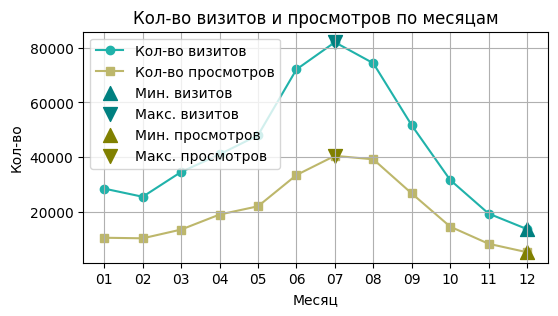

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))

plt.plot(monthly_visits.iloc[:, 0], monthly_visits.iloc[:, 1], label="Кол-во визитов", marker="o", color="lightseagreen", zorder=1)
plt.plot(monthly_views.iloc[:, 0], monthly_views.iloc[:, 1], label="Кол-во просмотров", marker="s", color="darkkhaki", zorder=1)

min_idx_visits = monthly_visits["Кол-во визитов"].idxmin()
max_idx_visits = monthly_visits["Кол-во визитов"].idxmax()

min_idx_views = monthly_views["Кол-во просмотров"].idxmin()
max_idx_views = monthly_views["Кол-во просмотров"].idxmax()

plt.scatter(monthly_visits.loc[min_idx_visits, "Месяц"], monthly_visits.loc[min_idx_visits, "Кол-во визитов"], color="teal", s=100, marker="^", label="Мин. визитов")
plt.scatter(monthly_visits.loc[max_idx_visits, "Месяц"], monthly_visits.loc[max_idx_visits, "Кол-во визитов"], color="teal", s=100, marker="v", label="Макс. визитов")

plt.scatter(monthly_views.loc[min_idx_views, "Месяц"], monthly_views.loc[min_idx_views, "Кол-во просмотров"], color="olive", s=100, marker="^", label="Мин. просмотров")
plt.scatter(monthly_views.loc[max_idx_views, "Месяц"], monthly_views.loc[max_idx_views, "Кол-во просмотров"], color="olive", s=100, marker="v", label="Макс. просмотров")

plt.title("Кол-во визитов и просмотров по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

По результатам самых базовых метрик (количество посещений сайта и просмотров экскурсии) наиболее удачным месяцем является *июль*, а наименее – *декабрь*.

Далее посмотрим на график отношения этих двух метрик.

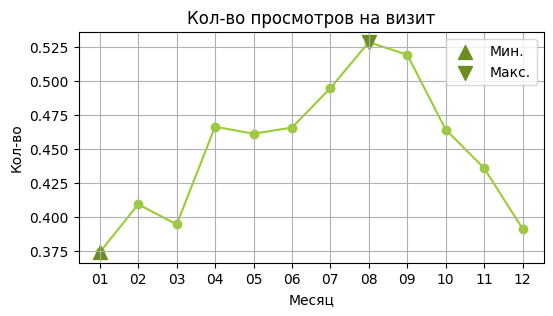

In [ ]:
plt.figure(figsize=(6, 3))

plt.plot(avg_pp_monthly_views.iloc[:, 0], avg_pp_monthly_views.iloc[:, 1], marker="o", color="yellowgreen", zorder=1)

min_idx_avg = avg_pp_monthly_views["Кол-во просмотров экскурсий на один визит"].idxmin()
max_idx_avg = avg_pp_monthly_views["Кол-во просмотров экскурсий на один визит"].idxmax()

plt.scatter(avg_pp_monthly_views.loc[min_idx_avg, "Месяц"], avg_pp_monthly_views.loc[min_idx_avg, "Кол-во просмотров экскурсий на один визит"], color="olivedrab", s=100, marker="^", label="Мин.")
plt.scatter(avg_pp_monthly_views.loc[max_idx_avg, "Месяц"], avg_pp_monthly_views.loc[max_idx_avg, "Кол-во просмотров экскурсий на один визит"], color="olivedrab", s=100, marker="v", label="Макс.")

plt.title("Кол-во просмотров на визит")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

Видим, что в среднем один посетитель сайта просматривает большее количество экскурсий в *августе*, а меньше всего в *январе*.

Перейдем к метрикам, связанных с заказами!

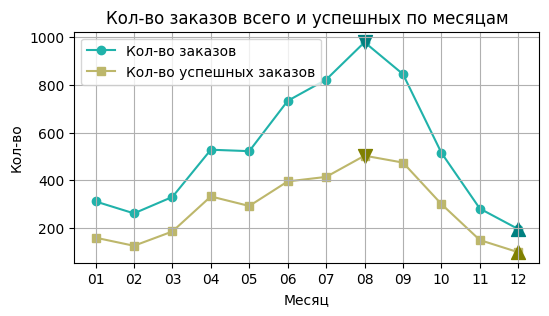

In [ ]:
plt.figure(figsize=(6, 3))

plt.plot(monthly_orders.iloc[:, 0], monthly_orders.iloc[:, 1], label="Кол-во заказов", marker="o", color="lightseagreen", zorder=1)
plt.plot(monthly_held_orders.iloc[:, 0], monthly_held_orders.iloc[:, 1], label="Кол-во успешных заказов", marker="s", color="darkkhaki", zorder=1)

min_idx_mo = monthly_orders["Кол-во заказов"].idxmin()
max_idx_mo = monthly_orders["Кол-во заказов"].idxmax()

min_idx_mho = monthly_held_orders["Кол-во успешных заказов"].idxmin()
max_idx_mho = monthly_held_orders["Кол-во успешных заказов"].idxmax()

plt.scatter(monthly_orders.loc[min_idx_mo, "Месяц"], monthly_orders.loc[min_idx_mo, "Кол-во заказов"], color="teal", s=100, marker="^")
plt.scatter(monthly_orders.loc[max_idx_mo, "Месяц"], monthly_orders.loc[max_idx_mo, "Кол-во заказов"], color="teal", s=100, marker="v")

plt.scatter(monthly_held_orders.loc[min_idx_mho, "Месяц"], monthly_held_orders.loc[min_idx_mho, "Кол-во успешных заказов"], color="olive", s=100, marker="^")
plt.scatter(monthly_held_orders.loc[max_idx_mho, "Месяц"], monthly_held_orders.loc[max_idx_mho, "Кол-во успешных заказов"], color="olive", s=100, marker="v")

plt.title("Кол-во заказов всего и успешных по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

По этому графику видим, что значения заказов и успешных заказов практически пропорциональны, что логично, и, соответвенно, для обоих метрик наилучшим месяцем является *август*, а наихудшим с минимальным количеством заказов – *декабрь*.

Посмотрим на отношение этих двух метрик.

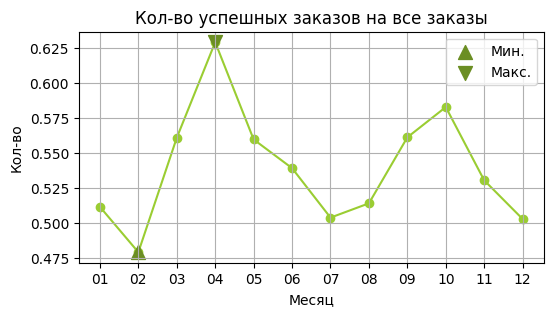

In [ ]:
plt.figure(figsize=(6, 3))

plt.plot(held_orders_per_orders.iloc[:, 0], held_orders_per_orders.iloc[:, 1], marker="o", color="yellowgreen", zorder=1)

min_idx_avg = held_orders_per_orders["Кол-во успешных заказов на все заказы"].idxmin()
max_idx_avg = held_orders_per_orders["Кол-во успешных заказов на все заказы"].idxmax()

plt.scatter(held_orders_per_orders.loc[min_idx_avg, "Месяц"], held_orders_per_orders.loc[min_idx_avg, "Кол-во успешных заказов на все заказы"], color="olivedrab", s=100, marker="^", label="Мин.")
plt.scatter(held_orders_per_orders.loc[max_idx_avg, "Месяц"], held_orders_per_orders.loc[max_idx_avg, "Кол-во успешных заказов на все заказы"], color="olivedrab", s=100, marker="v", label="Макс.")

plt.title("Кол-во успешных заказов на все заказы")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

Судя по графику ситуация с этим отношением не самая простая, и репрезентативности по "удачливости" месяца в нем достаточно мало. Я думаю эту информацию можно использовать в целях оценки качества оплаты, потому что зачастую заказ отменяется из-за системы, или копать глубже – почему столько отмененных заказов в июле, если это отмены от пользователей.

Посмотрим финальную метрику – конверсию визита в успешный заказ!

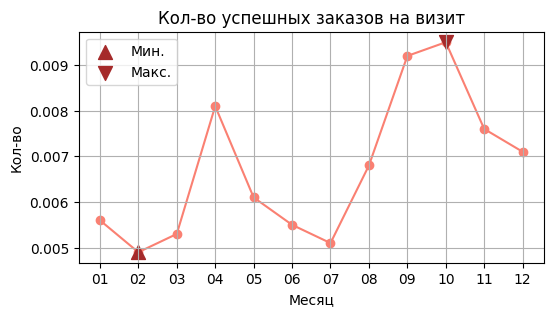

In [ ]:
plt.figure(figsize=(6, 3))

plt.plot(held_orders_per_visit.iloc[:, 0], held_orders_per_visit.iloc[:, 1], marker="o", color="salmon", zorder=1)

min_idx_hopv = held_orders_per_visit["Кол-во успешных заказов на визит"].idxmin()
max_idx_hopv = held_orders_per_visit["Кол-во успешных заказов на визит"].idxmax()

plt.scatter(held_orders_per_visit.loc[min_idx_hopv, "Месяц"], held_orders_per_visit.loc[min_idx_hopv, "Кол-во успешных заказов на визит"], color="brown", s=100, marker="^", label="Мин.")
plt.scatter(held_orders_per_visit.loc[max_idx_hopv, "Месяц"], held_orders_per_visit.loc[max_idx_hopv, "Кол-во успешных заказов на визит"], color="brown", s=100, marker="v", label="Макс.")

plt.title("Кол-во успешных заказов на визит")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

Можем сделать вывод, что месяц с самой высокой конверсией визита в успешный заказ – *октябрь*, когда как наихудшей конверсией обладает *февраль*, а за ним – *июль*.

Выводы по полученным метрикам привожу в отчете! Переходим к следующему пункту.

**3.Необходимо построить прогноз визитов для органического канала трафика для июля-сентября 2024 года по месяцам.**

Для прогнозирования лучше всего рассмотреть полный доступный временной ряд из таблицы visits (2023-03-01 по 2024-06-30), так как возможно мы уловим сезонные компоненты при повторении месяцев и прогноз будет точнее. Сначала достанем нужный нам DF при utm_medium=organic и сгруппируем по месяцам.

In [ ]:
conn.execute("""
CREATE TABLE visits_organic AS
  SELECT strftime("%Y-%m", started_at) AS "Месяц", COUNT(id) AS "Визиты"
  FROM visits
  WHERE utm_medium="organic"
  GROUP BY "Месяц"
""")

conn.commit()

query = """
SELECT *
FROM visits_organic
"""

visits_organic = pd.read_sql_query(query, conn)
print(visits_organic)

      Месяц  Визиты
0   2023-03   29111
1   2023-04   33716
2   2023-05   43032
3   2023-06   63135
4   2023-07   81925
5   2023-08   74270
6   2023-09   51649
7   2023-10   31743
8   2023-11   19486
9   2023-12   13826
10  2024-01   28582
11  2024-02   25612
12  2024-03   34662
13  2024-04   41046
14  2024-05   48028
15  2024-06   72014


Я буду использовать модель SARIMA (ARIMA с сезонной компонентой), так как это актуальный и удобный способ прогнозирования временных рядов.

In [ ]:
# Преобразуем временные данные из DF visits_organic в временной формат (из текстового)
print(type(visits_organic.loc[0, "Месяц"]))
visits_organic["Месяц"] = pd.to_datetime(visits_organic["Месяц"])
print(type(visits_organic.loc[0, "Месяц"]))

# Индексируем по дате
visits_organic.set_index("Месяц", inplace=True)
print(visits_organic)

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
            Визиты
Месяц             
2023-03-01   29111
2023-04-01   33716
2023-05-01   43032
2023-06-01   63135
2023-07-01   81925
2023-08-01   74270
2023-09-01   51649
2023-10-01   31743
2023-11-01   19486
2023-12-01   13826
2024-01-01   28582
2024-02-01   25612
2024-03-01   34662
2024-04-01   41046
2024-05-01   48028
2024-06-01   72014


/tmp/ipython-input-395-1678744373.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


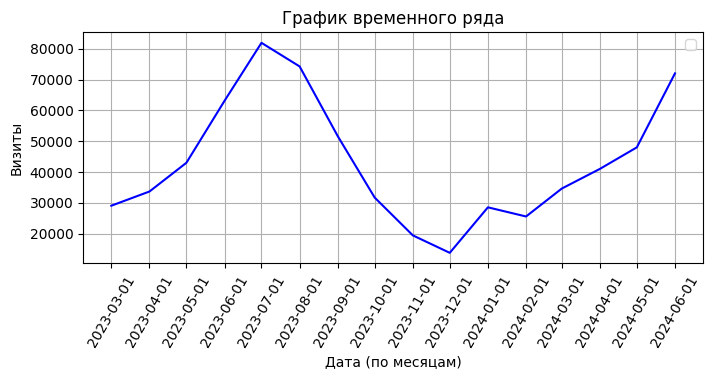

In [ ]:
# Визуализируем ряд, чтобы его оценить
plt.figure(figsize=(8, 3))

plt.plot(visits_organic["Визиты"], color="blue")

plt.title("График временного ряда")
plt.xlabel("Дата (по месяцам)")
plt.xticks(visits_organic.index, rotation=60)
plt.ylabel("Визиты")
plt.legend()
plt.grid(True)

plt.show()

Очевидно присутсвует сезонность. Есть предположение, что в июле нас ждет новый пик, и после августа достаточно резко снижение кол-ва визитов. Можем утверждать, что при таком тренде временной ряд не стационарен, но на всякий случай проверим.

In [ ]:
# Проверим ряд на стационарность тестом ADF (тест Дики — Фуллера)
from statsmodels.tsa.stattools import adfuller

result = adfuller(visits_organic["Визиты"], autolag="AIC")
p_value = result[1]
print(p_value)

0.6701962505842751


Так как p-value > 0.05 - ряд нестационарен, но так как мы используем ARIMA/SARIMA, а не ARMA, модель сама работает с трендом и нестационарностью.

Найдем лучшие параметры для модели (p, d, q) и (P, D, Q)

In [ ]:
# К сожалению в Google Colab не работет эта библиотека, поэтому будем руками
#from pmdarima import auto_arima

#model = auto_arima(visits_organic, seasonal=True, m=12, trace=True)
#print(model.summary())

In [ ]:
# Использую открытый код для ручного подбора лучших параметров (выбирает с минимальным AIC)
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def search_optimal_sarima(time_series, seasonal_cycle):
    order_vals = diff_vals = ma_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]

    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = sm.tsa.statespace.SARIMAX(time_series,
                                                         order=order_param,
                                                         seasonal_order=seasonal_param,
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)

                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except:
                continue

    print("ARIMA{}x{} - AIC:{}".format(optimal_order_param, optimal_seasonal_param, smallest_aic))

seasonal_cycle_length = 12
search_optimal_sarima(visits_organic, seasonal_cycle_length)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters excep

ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:4.0


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Va

Получили следующий результат: ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:4.0. Весьма любопытно. Получилась очень минималистичная модель, где у нас остались только сезонные компоненты (нет авторегрессии, нет тренда). Тогда перейдем к самой модели и к прогнозированию.

In [ ]:
# Применяем модель
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(visits_organic, order=(0,0,0), seasonal_order=(0,1,1,12))

results = model.fit()
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                 SARIMAX Results                                  
Dep. Variable:                     Визиты   No. Observations:                   16
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                 -34.964
Date:                    Fri, 25 Jul 2025   AIC                             73.928
Time:                            19:23:56   BIC                             72.701
Sample:                        03-01-2023   HQIC                            71.234
                             - 06-01-2024                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.2411      0.029      8.343      0.000       0.184       0.298
sigma2      1.874e+06   1.59e-09   1.18e+15      0.000    1.87e+06    1.87e+06
Ljung-Box (L1) (Q): 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3160: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3160: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


2024-07-01    94331
2024-08-01    85516
2024-09-01    59470
Freq: MS, Name: predicted_mean, dtype: int64


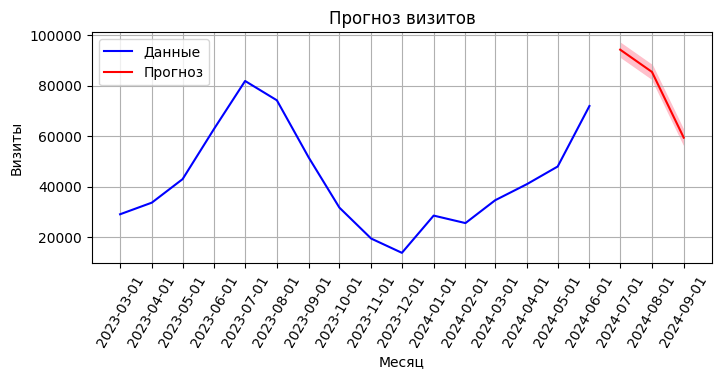

In [ ]:
# Получим прогнозные значения
forecast = results.get_forecast(steps=3)
forecast_mean = forecast.predicted_mean.astype(int)
print(forecast_mean)

forecast_ci = forecast.conf_int()

# Построим график, где соединим имеющиеся значения и прогнозные + доверительный интервал
plt.figure(figsize=(8, 3))
plt.plot(visits_organic, label="Данные", color="blue")

plt.plot(forecast_mean, label="Прогноз", color="red")
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="pink")

plt.title("Прогноз визитов")
plt.xlabel("Месяц")
plt.ylabel("Визиты")
plt.legend()
plt.xticks(list(visits_organic.index) + list(forecast_mean.index), rotation=60)
plt.grid(True)
plt.show()

Получили прогноз. Теперь ответим на вопрос **3.а Как изменится прогноз, если органический трафик будет работать эффективнее на 5%?**

2024-07-01    99047
2024-08-01    89791
2024-09-01    62443
Freq: MS, Name: predicted_mean, dtype: int64


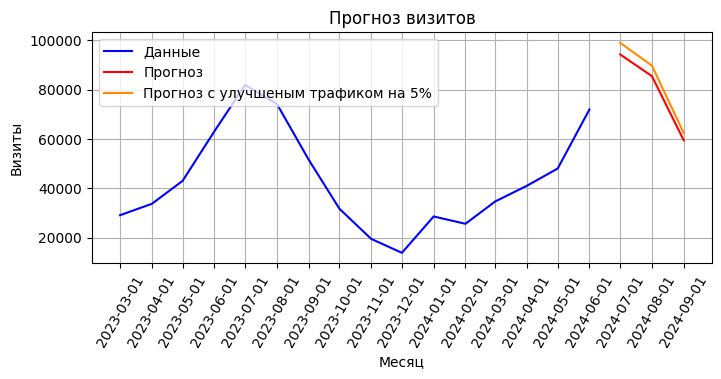

In [ ]:
# Для предыдущего прогноза увеличим значения в 1,05 раз
# Получим прогнозные значения
forecast_mean_eff = (forecast_mean * 1.05).astype(int)
print(forecast_mean_eff)

forecast_ci_eff = forecast_ci * 1.05

# Построим график, где соединим имеющиеся значения и прогнозные + доверительный интервал
plt.figure(figsize=(8, 3))
plt.plot(visits_organic, label="Данные", color="blue")

plt.plot(forecast_mean, label="Прогноз", color="red")


plt.plot(forecast_mean_eff, label="Прогноз с улучшеным трафиком на 5%", color="darkorange")

plt.title("Прогноз визитов")
plt.xlabel("Месяц")
plt.ylabel("Визиты")
plt.legend()
plt.xticks(list(visits_organic.index) + list(forecast_mean_eff.index), rotation=60)
plt.grid(True)
plt.show()

Вот как будет выглядеть график в случае увеличения прогноза на 5%

Переходим к следующему пункту!

**4.Выберем канал с самым высоким потенциалом**. Для начала подумаем, какие характеристики у канала с высоким потенциалом.


У нас всего 3 utm_medium (=organic/affiliate/cpc). Создадим по таблице для последних двух каналов и рассмотрим основные метрики -> сравним на графиках. Аналогично пункту 2 рассматриваем последний год.

In [ ]:
# Создаем таблицу visits при utm_medium=organic (для удобного названия)
conn.execute("""
CREATE TABLE visits_year_org AS
  SELECT *
  FROM visits
  WHERE started_at >= "2023-07-01" AND utm_medium="organic"
""")

conn.commit()

# Создаем таблицу visits при utm_medium=affiliate
conn.execute("""
CREATE TABLE visits_year_aff AS
  SELECT *
  FROM visits
  WHERE started_at >= "2023-07-01" AND utm_medium="affiliate"
""")

conn.commit()

# Создаем таблицу visits при utm_medium=cpc
conn.execute("""
CREATE TABLE visits_year_cpc AS
  SELECT *
  FROM visits
  WHERE started_at >= "2023-07-01" AND utm_medium="cpc"
""")

conn.commit()

Я решила, что практичнее будет считать метрики и для органического канала, чем искать его выше:)

In [ ]:
# Кол-во визитов по месяцам для каждого канала
query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(id) AS "Кол-во визитов (org)"
FROM visits_year_org
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_visits_org = pd.read_sql_query(query, conn)

query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(id) AS "Кол-во визитов (aff)"
FROM visits_year_aff
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_visits_aff = pd.read_sql_query(query, conn)

query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(id) AS "Кол-во визитов (cpc)"
FROM visits_year_cpc
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_visits_cpc = pd.read_sql_query(query, conn)

# Объединяем в один красивый df
monthly_visits_merged = pd.merge(monthly_visits_org, monthly_visits_aff, on="Месяц")
monthly_visits_all = pd.merge(monthly_visits_merged, monthly_visits_cpc, on="Месяц")
print(monthly_visits_all)

   Месяц  Кол-во визитов (org)  Кол-во визитов (aff)  Кол-во визитов (cpc)
0     01                 28582                  2103                  2199
1     02                 25612                  1642                  2749
2     03                 34662                  2072                  4671
3     04                 41046                  2175                  7520
4     05                 48028                  2519                  9099
5     06                 72014                  4583                 13411
6     07                 81925                  4306                  5874
7     08                 74270                  4749                  4437
8     09                 51649                  3295                  1945
9     10                 31743                  2322                  1854
10    11                 19486                  1508                  1555
11    12                 13826                  1374                  1523


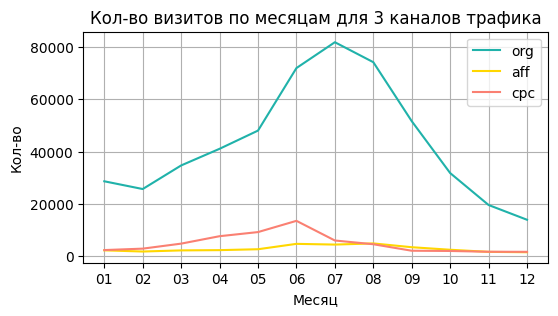

In [ ]:
# Строим график
plt.figure(figsize=(6, 3))

plt.plot(monthly_visits_all.iloc[:, 0], monthly_visits_all.iloc[:, 1], label="org", color="lightseagreen")
plt.plot(monthly_visits_all.iloc[:, 0], monthly_visits_all.iloc[:, 2], label="aff", color="gold")
plt.plot(monthly_visits_all.iloc[:, 0], monthly_visits_all.iloc[:, 3], label="cpc", color="salmon")

plt.title("Кол-во визитов по месяцам для 3 каналов трафика")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Кол-во просмотров по месяцам для каждого канала
query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(views.id) AS "Кол-во просмотров (org)"
FROM views
     INNER JOIN visits_year_org ON visits_year_org.id = views.visit_id
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_views_org = pd.read_sql_query(query, conn)

query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(views.id) AS "Кол-во просмотров (aff)"
FROM views
     INNER JOIN visits_year_aff ON visits_year_aff.id = views.visit_id
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_views_aff = pd.read_sql_query(query, conn)

query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(views.id) AS "Кол-во просмотров (cpc)"
FROM views
     INNER JOIN visits_year_cpc ON visits_year_cpc.id = views.visit_id
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_views_cpc = pd.read_sql_query(query, conn)

monthly_views_merged = pd.merge(monthly_views_org, monthly_views_aff, on="Месяц")
monthly_views_all = pd.merge(monthly_views_merged, monthly_views_cpc, on="Месяц")
print(monthly_views_all)

   Месяц  Кол-во просмотров (org)  Кол-во просмотров (aff)  \
0     01                    10682                     2817   
1     02                    10477                     2338   
2     03                    13665                     2642   
3     04                    19139                     2891   
4     05                    22147                     3352   
5     06                    33533                     5736   
6     07                    40531                     5734   
7     08                    39258                     6414   
8     09                    26825                     4290   
9     10                    14735                     2963   
10    11                     8491                     1502   
11    12                     5408                     1697   

    Кол-во просмотров (cpc)  
0                      1625  
1                      2853  
2                      5578  
3                      8067  
4                      9397  
5            

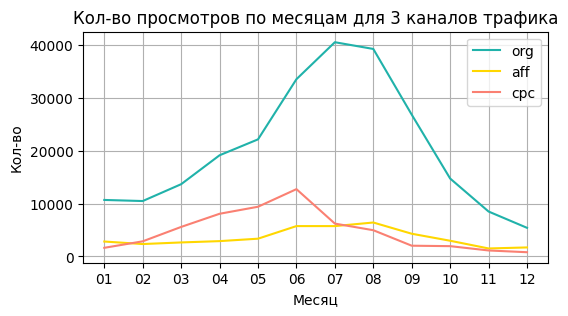

In [ ]:
# Строим график
plt.figure(figsize=(6, 3))

plt.plot(monthly_views_all.iloc[:, 0], monthly_views_all.iloc[:, 1], label="org", color="lightseagreen")
plt.plot(monthly_views_all.iloc[:, 0], monthly_views_all.iloc[:, 2], label="aff", color="gold")
plt.plot(monthly_views_all.iloc[:, 0], monthly_views_all.iloc[:, 3], label="cpc", color="salmon")

plt.title("Кол-во просмотров по месяцам для 3 каналов трафика")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Кол-во просмотренных экскурсий за визит
df_new = monthly_views_all.merge(monthly_visits_all, on="Месяц")
df_new["Кол-во просмотров экскурсий на один визит (org)"] = df_new["Кол-во просмотров (org)"] / df_new["Кол-во визитов (org)"]
df_new["Кол-во просмотров экскурсий на один визит (aff)"] = df_new["Кол-во просмотров (aff)"] / df_new["Кол-во визитов (aff)"]
df_new["Кол-во просмотров экскурсий на один визит (cpc)"] = df_new["Кол-во просмотров (cpc)"] / df_new["Кол-во визитов (cpc)"]
avg_pp_monthly_views_all = df_new[["Месяц", "Кол-во просмотров экскурсий на один визит (org)", "Кол-во просмотров экскурсий на один визит (aff)", "Кол-во просмотров экскурсий на один визит (cpc)"]]
print(avg_pp_monthly_views_all)

   Месяц  Кол-во просмотров экскурсий на один визит (org)  \
0     01                                         0.373732   
1     02                                         0.409066   
2     03                                         0.394236   
3     04                                         0.466282   
4     05                                         0.461127   
5     06                                         0.465646   
6     07                                         0.494733   
7     08                                         0.528585   
8     09                                         0.519371   
9     10                                         0.464197   
10    11                                         0.435749   
11    12                                         0.391147   

    Кол-во просмотров экскурсий на один визит (aff)  \
0                                          1.339515   
1                                          1.423873   
2                                        

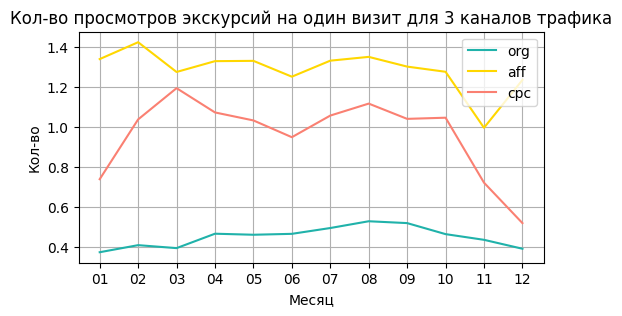

In [ ]:
# Строим график
plt.figure(figsize=(6, 3))

plt.plot(avg_pp_monthly_views_all.iloc[:, 0], avg_pp_monthly_views_all.iloc[:, 1], label="org", color="lightseagreen")
plt.plot(avg_pp_monthly_views_all.iloc[:, 0], avg_pp_monthly_views_all.iloc[:, 2], label="aff", color="gold")
plt.plot(avg_pp_monthly_views_all.iloc[:, 0], avg_pp_monthly_views_all.iloc[:, 3], label="cpc", color="salmon")

plt.title("Кол-во просмотров экскурсий на один визит для 3 каналов трафика")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Общее кол-во заказов
query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(orders.id) AS "Кол-во заказов (org)"
FROM orders
     INNER JOIN visits_year_org ON visits_year_org.id = orders.visit_id
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_orders_org = pd.read_sql_query(query, conn)

query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(orders.id) AS "Кол-во заказов (aff)"
FROM orders
     INNER JOIN visits_year_aff ON visits_year_aff.id = orders.visit_id
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_orders_aff = pd.read_sql_query(query, conn)

query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(orders.id) AS "Кол-во заказов (cpc)"
FROM orders
     INNER JOIN visits_year_cpc ON visits_year_cpc.id = orders.visit_id
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_orders_cpc = pd.read_sql_query(query, conn)

monthly_orders_merged = pd.merge(monthly_orders_org, monthly_orders_aff, on="Месяц")
monthly_orders_all = pd.merge(monthly_orders_merged, monthly_orders_cpc, on="Месяц")
print(monthly_orders_all)

   Месяц  Кол-во заказов (org)  Кол-во заказов (aff)  Кол-во заказов (cpc)
0     01                   311                    73                    21
1     02                   261                    54                    48
2     03                   330                    85                   104
3     04                   528                    78                   178
4     05                   522                   100                   187
5     06                   733                   131                   207
6     07                   822                   172                   124
7     08                   979                   217                   106
8     09                   845                   146                    59
9     10                   515                   114                    60
10    11                   281                    41                    45
11    12                   195                    67                    12


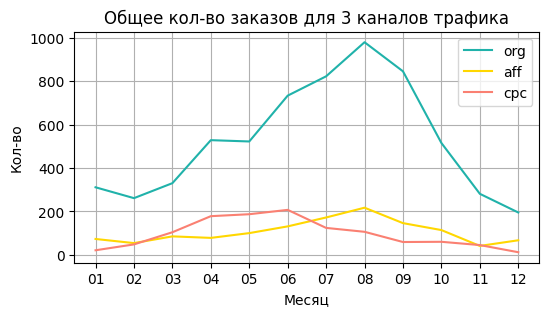

In [ ]:
# Строим график
plt.figure(figsize=(6, 3))

plt.plot(monthly_orders_all.iloc[:, 0], monthly_orders_all.iloc[:, 1], label="org", color="lightseagreen")
plt.plot(monthly_orders_all.iloc[:, 0], monthly_orders_all.iloc[:, 2], label="aff", color="gold")
plt.plot(monthly_orders_all.iloc[:, 0], monthly_orders_all.iloc[:, 3], label="cpc", color="salmon")

plt.title("Общее кол-во заказов для 3 каналов трафика")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Общее кол-во успешных заказов
query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(orders.id) AS "Кол-во успешных заказов (org)"
FROM orders
     INNER JOIN visits_year_org ON visits_year_org.id = orders.visit_id
WHERE orders.state = "held"
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_held_orders_org = pd.read_sql_query(query, conn)

query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(orders.id) AS "Кол-во успешных заказов (aff)"
FROM orders
     INNER JOIN visits_year_aff ON visits_year_aff.id = orders.visit_id
WHERE orders.state = "held"
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_held_orders_aff = pd.read_sql_query(query, conn)

query = """
SELECT strftime("%m", started_at) AS "Месяц", COUNT(orders.id) AS "Кол-во успешных заказов (cpc)"
FROM orders
     INNER JOIN visits_year_cpc ON visits_year_cpc.id = orders.visit_id
WHERE orders.state = "held"
GROUP BY "Месяц"
ORDER BY "Месяц"
"""
monthly_held_orders_cpc = pd.read_sql_query(query, conn)

monthly_held_orders_merged = pd.merge(monthly_held_orders_org, monthly_held_orders_aff, on="Месяц")
monthly_held_orders_all = pd.merge(monthly_held_orders_merged, monthly_held_orders_cpc, on="Месяц")
print(monthly_held_orders_all)

   Месяц  Кол-во успешных заказов (org)  Кол-во успешных заказов (aff)  \
0     01                            159                             27   
1     02                            125                             27   
2     03                            185                             35   
3     04                            332                             37   
4     05                            292                             49   
5     06                            395                             63   
6     07                            414                             82   
7     08                            503                            106   
8     09                            474                             64   
9     10                            300                             51   
10    11                            149                             18   
11    12                             98                             34   

    Кол-во успешных заказов (cpc)  
0

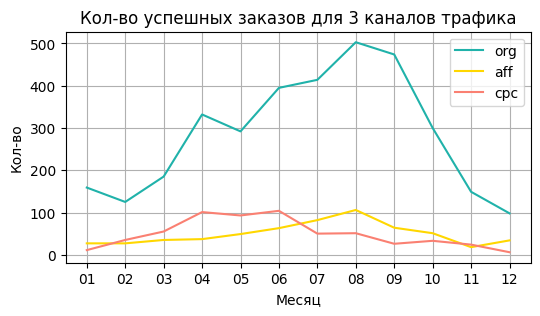

In [ ]:
# Строим график
plt.figure(figsize=(6, 3))

plt.plot(monthly_held_orders_all.iloc[:, 0], monthly_held_orders_all.iloc[:, 1], label="org", color="lightseagreen")
plt.plot(monthly_held_orders_all.iloc[:, 0], monthly_held_orders_all.iloc[:, 2], label="aff", color="gold")
plt.plot(monthly_held_orders_all.iloc[:, 0], monthly_held_orders_all.iloc[:, 3], label="cpc", color="salmon")

plt.title("Кол-во успешных заказов для 3 каналов трафика")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Отношение кол-ва успешных заказов к общему
df_new = monthly_orders_all.merge(monthly_held_orders_all, on="Месяц")
df_new["Отношение успешных заказов ко всем заказам (org)"] = round(df_new["Кол-во успешных заказов (org)"] / df_new["Кол-во заказов (org)"], 4)
df_new["Отношение успешных заказов ко всем заказам (aff)"] = round(df_new["Кол-во успешных заказов (aff)"] / df_new["Кол-во заказов (aff)"], 4)
df_new["Отношение успешных заказов ко всем заказам (cpc)"] = round(df_new["Кол-во успешных заказов (cpc)"] / df_new["Кол-во заказов (cpc)"], 4)
held_orders_per_orders_all = df_new[["Месяц", "Отношение успешных заказов ко всем заказам (org)", "Отношение успешных заказов ко всем заказам (aff)", "Отношение успешных заказов ко всем заказам (cpc)"]]
print(held_orders_per_orders_all)

   Месяц  Отношение успешных заказов ко всем заказам (org)  \
0     01                                            0.5113   
1     02                                            0.4789   
2     03                                            0.5606   
3     04                                            0.6288   
4     05                                            0.5594   
5     06                                            0.5389   
6     07                                            0.5036   
7     08                                            0.5138   
8     09                                            0.5609   
9     10                                            0.5825   
10    11                                            0.5302   
11    12                                            0.5026   

    Отношение успешных заказов ко всем заказам (aff)  \
0                                             0.3699   
1                                             0.5000   
2                        

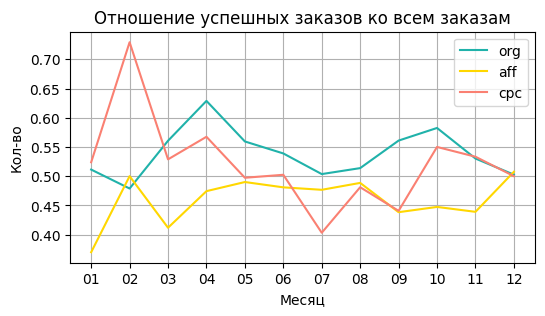

In [ ]:
# Строим график
plt.figure(figsize=(6, 3))

plt.plot(held_orders_per_orders_all.iloc[:, 0], held_orders_per_orders_all.iloc[:, 1], label="org", color="lightseagreen")
plt.plot(held_orders_per_orders_all.iloc[:, 0], held_orders_per_orders_all.iloc[:, 2], label="aff", color="gold")
plt.plot(held_orders_per_orders_all.iloc[:, 0], held_orders_per_orders_all.iloc[:, 3], label="cpc", color="salmon")

plt.title("Отношение успешных заказов ко всем заказам")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Конверсия визита в успешный заказ
df_new = monthly_visits_all.merge(monthly_held_orders_all, on="Месяц")
df_new["Кол-во успешных заказов на визит (org)"] = round(df_new["Кол-во успешных заказов (org)"] / df_new["Кол-во визитов (org)"], 4)
df_new["Кол-во успешных заказов на визит (aff)"] = round(df_new["Кол-во успешных заказов (aff)"] / df_new["Кол-во визитов (aff)"], 4)
df_new["Кол-во успешных заказов на визит (cpc)"] = round(df_new["Кол-во успешных заказов (cpc)"] / df_new["Кол-во визитов (cpc)"], 4)
held_orders_per_visit_all = df_new[["Месяц", "Кол-во успешных заказов на визит (org)", "Кол-во успешных заказов на визит (aff)", "Кол-во успешных заказов на визит (cpc)"]]
print(held_orders_per_visit_all)

   Месяц  Кол-во успешных заказов на визит (org)  \
0     01                                  0.0056   
1     02                                  0.0049   
2     03                                  0.0053   
3     04                                  0.0081   
4     05                                  0.0061   
5     06                                  0.0055   
6     07                                  0.0051   
7     08                                  0.0068   
8     09                                  0.0092   
9     10                                  0.0095   
10    11                                  0.0076   
11    12                                  0.0071   

    Кол-во успешных заказов на визит (aff)  \
0                                   0.0128   
1                                   0.0164   
2                                   0.0169   
3                                   0.0170   
4                                   0.0195   
5                                   0.0137   
6

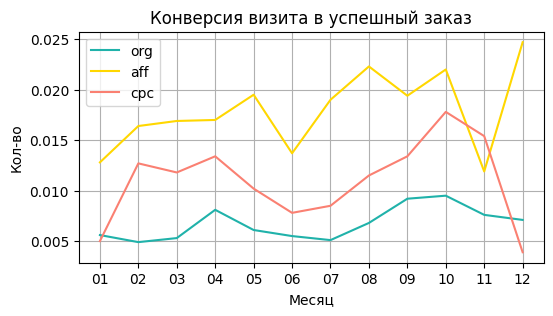

In [ ]:
# Строим график
plt.figure(figsize=(6, 3))

plt.plot(held_orders_per_visit_all.iloc[:, 0], held_orders_per_visit_all.iloc[:, 1], label="org", color="lightseagreen")
plt.plot(held_orders_per_visit_all.iloc[:, 0], held_orders_per_visit_all.iloc[:, 2], label="aff", color="gold")
plt.plot(held_orders_per_visit_all.iloc[:, 0], held_orders_per_visit_all.iloc[:, 3], label="cpc", color="salmon")

plt.title("Конверсия визита в успешный заказ")
plt.xlabel("Месяц")
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

Попробуем посмотреть прогноз для конверсии по всем каналам. Будем делать шаги по аналогии с 3 пунктом.

In [ ]:
# Создадим новые таблицы для всего временного промежутка
conn.execute("""
CREATE TABLE conversion_org AS
  SELECT query1."Месяц", ROUND((query2.orders_count * 1.0 / query1.visits_count), 4) AS "Кол-во успешных заказов на визит (org)"
  FROM (SELECT strftime("%Y-%m", started_at) AS "Месяц", COUNT(id) AS visits_count
        FROM visits
        WHERE utm_medium="organic"
        GROUP BY "Месяц") query1 INNER JOIN

                                     (SELECT strftime("%Y-%m", visits.started_at) AS "Месяц", COUNT(orders.id) AS orders_count
                                      FROM orders
                                           INNER JOIN visits ON visits.id = orders.visit_id
                                      WHERE visits.utm_medium="organic" AND orders.state="held"
                                      GROUP BY "Месяц") query2 USING("Месяц")
  GROUP BY "Месяц"
""")

conn.commit()

query = """
SELECT *
FROM conversion_org
"""

conversion_org = pd.read_sql_query(query, conn)
print(conversion_org)

      Месяц  Кол-во успешных заказов на визит (org)
0   2023-03                                  0.0077
1   2023-04                                  0.0093
2   2023-05                                  0.0076
3   2023-06                                  0.0054
4   2023-07                                  0.0051
5   2023-08                                  0.0068
6   2023-09                                  0.0092
7   2023-10                                  0.0095
8   2023-11                                  0.0076
9   2023-12                                  0.0071
10  2024-01                                  0.0056
11  2024-02                                  0.0049
12  2024-03                                  0.0053
13  2024-04                                  0.0081
14  2024-05                                  0.0061
15  2024-06                                  0.0055


In [ ]:
conn.execute("""
CREATE TABLE conversion_aff AS
  SELECT query1."Месяц", ROUND((query2.orders_count * 1.0 / query1.visits_count), 4) AS "Кол-во успешных заказов на визит (aff)"
  FROM (SELECT strftime("%Y-%m", started_at) AS "Месяц", COUNT(id) AS visits_count
        FROM visits
        WHERE utm_medium="affiliate"
        GROUP BY "Месяц") query1 INNER JOIN

                                     (SELECT strftime("%Y-%m", visits.started_at) AS "Месяц", COUNT(orders.id) AS orders_count
                                      FROM orders
                                           INNER JOIN visits ON visits.id = orders.visit_id
                                      WHERE visits.utm_medium="affiliate" AND orders.state="held"
                                      GROUP BY "Месяц") query2 USING("Месяц")
  GROUP BY "Месяц"
""")

conn.commit()

query = """
SELECT *
FROM conversion_aff
"""

conversion_aff = pd.read_sql_query(query, conn)
print(conversion_aff)

      Месяц  Кол-во успешных заказов на визит (aff)
0   2023-03                                  0.0280
1   2023-04                                  0.0260
2   2023-05                                  0.0245
3   2023-06                                  0.0202
4   2023-07                                  0.0190
5   2023-08                                  0.0223
6   2023-09                                  0.0194
7   2023-10                                  0.0220
8   2023-11                                  0.0119
9   2023-12                                  0.0247
10  2024-01                                  0.0128
11  2024-02                                  0.0164
12  2024-03                                  0.0169
13  2024-04                                  0.0170
14  2024-05                                  0.0195
15  2024-06                                  0.0137


In [ ]:
conn.execute("""
CREATE TABLE conversion_cpc AS
  SELECT query1."Месяц", ROUND((query2.orders_count * 1.0 / query1.visits_count), 4) AS "Кол-во успешных заказов на визит (cpc)"
  FROM (SELECT strftime("%Y-%m", started_at) AS "Месяц", COUNT(id) AS visits_count
        FROM visits
        WHERE utm_medium="cpc"
        GROUP BY "Месяц") query1 INNER JOIN

                                     (SELECT strftime("%Y-%m", visits.started_at) AS "Месяц", COUNT(orders.id) AS orders_count
                                      FROM orders
                                           INNER JOIN visits ON visits.id = orders.visit_id
                                      WHERE visits.utm_medium="cpc" AND orders.state="held"
                                      GROUP BY "Месяц") query2 USING("Месяц")
  GROUP BY "Месяц"
""")

conn.commit()

query = """
SELECT *
FROM conversion_cpc
"""

conversion_cpc = pd.read_sql_query(query, conn)
print(conversion_cpc)

      Месяц  Кол-во успешных заказов на визит (cpc)
0   2023-03                                  0.0156
1   2023-04                                  0.0154
2   2023-05                                  0.0097
3   2023-06                                  0.0093
4   2023-07                                  0.0085
5   2023-08                                  0.0115
6   2023-09                                  0.0134
7   2023-10                                  0.0178
8   2023-11                                  0.0154
9   2023-12                                  0.0039
10  2024-01                                  0.0050
11  2024-02                                  0.0127
12  2024-03                                  0.0118
13  2024-04                                  0.0134
14  2024-05                                  0.0102
15  2024-06                                  0.0078


In [ ]:
# Преобразуем временные даты из DF в временной формат (из текстового)
conversion_org["Месяц"] = pd.to_datetime(conversion_org["Месяц"])
conversion_aff["Месяц"] = pd.to_datetime(conversion_aff["Месяц"])
conversion_cpc["Месяц"] = pd.to_datetime(conversion_cpc["Месяц"])

# Индексируем по дате
conversion_org.set_index("Месяц", inplace=True)
conversion_aff.set_index("Месяц", inplace=True)
conversion_cpc.set_index("Месяц", inplace=True)

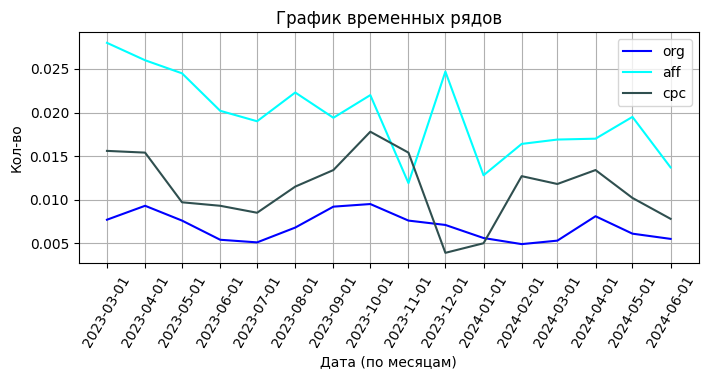

In [ ]:
# Визуализируем ряды, чтобы их оценить
plt.figure(figsize=(8, 3))

plt.plot(conversion_org["Кол-во успешных заказов на визит (org)"], color="blue", label="org")
plt.plot(conversion_aff["Кол-во успешных заказов на визит (aff)"], color="aqua", label="aff")
plt.plot(conversion_cpc["Кол-во успешных заказов на визит (cpc)"], color="darkslategrey", label="cpc")

plt.title("График временных рядов")
plt.xlabel("Дата (по месяцам)")
plt.xticks(conversion_org.index, rotation=60)
plt.ylabel("Кол-во")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Подбираем лучшие параметры
search_optimal_sarima(conversion_org, seasonal_cycle_length)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters excep

ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:-147.27412099131274


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/

org -> ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:-147.27412099131274

In [ ]:
search_optimal_sarima(conversion_aff, seasonal_cycle_length)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters excep

ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:-111.33273747124504


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/

aff -> ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:-111.33273747124504

In [ ]:
search_optimal_sarima(conversion_cpc, seasonal_cycle_length)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters excep

ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:-117.94468763997314


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:86

cpc -> ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:-117.94468763997314

In [ ]:
#org
model = SARIMAX(conversion_org, order=(1,0,0), seasonal_order=(0,0,0,12))

results_org = model.fit()

#aff
model = SARIMAX(conversion_aff, order=(1,0,1), seasonal_order=(0,0,0,12))

results_aff = model.fit()

#cpc
model = SARIMAX(conversion_cpc, order=(1,0,0), seasonal_order=(0,0,0,12))

results_cpc = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non

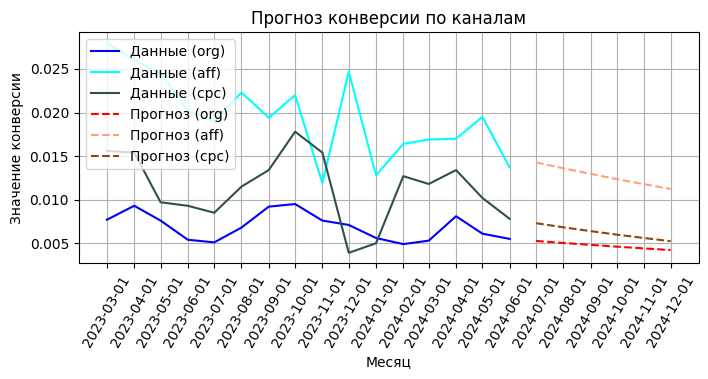

In [ ]:
# Получим прогнозные значения
forecast_org = results_org.get_forecast(steps=6)
forecast_mean_org = forecast_org.predicted_mean

forecast_aff = results_aff.get_forecast(steps=6)
forecast_mean_aff = forecast_aff.predicted_mean

forecast_cpc = results_cpc.get_forecast(steps=6)
forecast_mean_cpc = forecast_cpc.predicted_mean

# Построим график, где соединим имеющиеся значения и прогнозные
plt.figure(figsize=(8, 3))
plt.plot(conversion_org, label="Данные (org)", color="blue")
plt.plot(conversion_aff, label="Данные (aff)", color="aqua")
plt.plot(conversion_cpc, label="Данные (cpc)", color="darkslategrey")

plt.plot(forecast_mean_org, label="Прогноз (org)", color="red", linestyle="--")
plt.plot(forecast_mean_aff, label="Прогноз (aff)", color="lightsalmon", linestyle="--")
plt.plot(forecast_mean_cpc, label="Прогноз (cpc)", color="saddlebrown", linestyle="--")


plt.title("Прогноз конверсии по каналам")
plt.xlabel("Месяц")
plt.ylabel("Значение конверсии")
plt.legend(loc="upper left")
plt.xticks(list(conversion_org.index) + list(forecast_mean_org.index), rotation=60)
plt.grid(True)
plt.show()

Получается очень неприятная картинка, что модель восприняла спад слишком серьезно (просто проложила дальше), скорее всего повлияло маленькое количество данных и функция поиска параметров посчитала отсутсвие сезонности. Попробуем руками добавить сезонность и посмотреть на результат (возьмем такую же как и для визитов).

In [ ]:
#org
model = SARIMAX(conversion_org, order=(1,0,0), seasonal_order=(0,1,1,12))

results_org = model.fit()

#aff
model = SARIMAX(conversion_aff, order=(1,0,1), seasonal_order=(0,1,1,12))

results_aff = model.fit()

#cpc
model = SARIMAX(conversion_cpc, order=(1,0,0), seasonal_order=(0,1,1,12))

results_cpc = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No freq

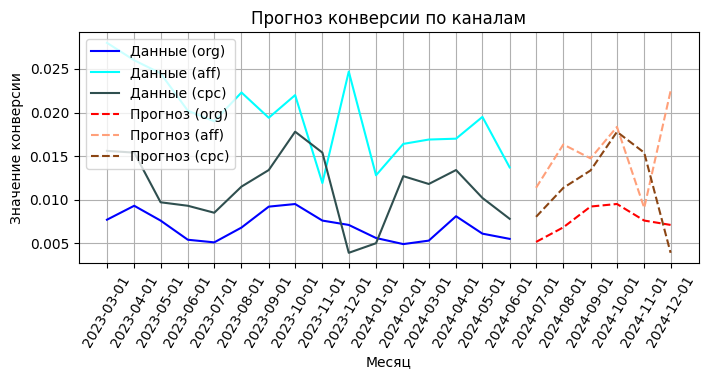

In [ ]:
# Получим прогнозные значения
forecast_org = results_org.get_forecast(steps=6)
forecast_mean_org = forecast_org.predicted_mean

forecast_aff = results_aff.get_forecast(steps=6)
forecast_mean_aff = forecast_aff.predicted_mean

forecast_cpc = results_cpc.get_forecast(steps=6)
forecast_mean_cpc = forecast_cpc.predicted_mean

# Построим график, где соединим имеющиеся значения и прогнозные
plt.figure(figsize=(8, 3))
plt.plot(conversion_org, label="Данные (org)", color="blue")
plt.plot(conversion_aff, label="Данные (aff)", color="aqua")
plt.plot(conversion_cpc, label="Данные (cpc)", color="darkslategrey")

plt.plot(forecast_mean_org, label="Прогноз (org)", color="red", linestyle="--")
plt.plot(forecast_mean_aff, label="Прогноз (aff)", color="lightsalmon", linestyle="--")
plt.plot(forecast_mean_cpc, label="Прогноз (cpc)", color="saddlebrown", linestyle="--")


plt.title("Прогноз конверсии по каналам")
plt.xlabel("Месяц")
plt.ylabel("Значение конверсии")
plt.legend(loc="upper left")
plt.xticks(list(conversion_org.index) + list(forecast_mean_org.index), rotation=60)
plt.grid(True)
plt.show()

Визуально такой прогноз больше похож на правду, но всё же лучше оставить скептический настрой.